# Week 2 Assignment
I'll be using data from the Cook County Coroner's office on deaths to find and map overdose deaths related to opiates.

In [2]:
# import required packages
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
import statistics

In [3]:
# import data with pandas
df = pd.read_csv('data/cookcounty_overdose.csv')

# Convert to geopandas dataframe
od_cook = gpd.GeoDataFrame(df, 
    geometry = gpd.points_from_xy(df['longitude'], df['latitude']), 
    crs = 'EPSG:4326')
od_cook.dtypes


/tmp/ipykernel_101/4239539136.py:2: DtypeWarning: Columns (15,16,20,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/cookcounty_overdose.csv')


Case Number                 object
Date of Incident            object
Date of Death               object
Age                        float64
Gender                      object
Race                        object
Latino                        bool
Manner of Death             object
Primary Cause               object
Primary Cause Line A        object
Primary Cause Line B        object
Primary Cause Line C        object
Secondary Cause             object
Gun Related                 object
Opioid Related              object
Cold Related                object
Heat Related                object
Commissioner District      float64
Incident Address            object
Incident City               object
Incident Zip Code           object
longitude                  float64
latitude                   float64
location                    object
Residence City              object
Residence Zip               object
OBJECTID                   float64
Chicago Ward               float64
Chicago Community Ar

In [4]:
# Preview sample of data
od_cook.head()

,Case Number,Date of Incident,Date of Death,Age,Gender,Race,Latino,Manner of Death,Primary Cause,Primary Cause Line A,...,longitude,latitude,location,Residence City,Residence Zip,OBJECTID,Chicago Ward,Chicago Community Area,COVID Related,geometry
0,ME2020-05711,05/15/2020 06:00:00 PM,05/15/2020 10:52:00 PM,67.0,Female,White,False,PENDING,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,38479.0,NaN,NaN,NaN,POINT EMPTY
1,ME2014-00627,09/21/2014 10:00:00 AM,09/21/2014 01:50:00 PM,25.0,Male,Black,False,UNDETERMINED,DROWNING,DROWNING,...,-87.615461,41.889480,"(41.88948019, -87.61546076)",NaN,60608,1.0,42.0,NEAR NORTH SIDE,False,POINT (-87.61546 41.88948)
2,ME2014-00649,09/22/2014 04:40:00 PM,09/22/2014 04:55:00 PM,61.0,Male,Black,False,NATURAL,HYPERTENSIVE ARTERIOSCLEROTIC CARDIOVASCULAR D...,HYPERTENSIVE ARTERIOSCLEROTIC CARDIOVASCULAR D...,...,-87.623221,41.507334,"(41.507334, -87.6232215)",NaN,60411,2.0,NaN,NaN,False,POINT (-87.62322 41.50733)
3,ME2014-00712,09/27/2014 04:58:00 PM,09/27/2014 05:10:00 PM,51.0,Male,White,False,NATURAL,DIABETIC KETOACIDOSIS,DIABETIC KETOACIDOSIS,...,NaN,NaN,NaN,NaN,60525,3.0,NaN,NaN,False,POINT EMPTY
4,ME2014-00792,10/02/2014 12:00:00 AM,10/02/2014 02:15:00 PM,55.0,Male,Black,False,NATURAL,HYPERTENSIVE AND ARTERIOSCLEROTIC CARDIOVASCUL...,HYPERTENSIVE AND ARTERIOSCLEROTIC CARDIOVASCUL...,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,False,POINT EMPTY


In [5]:
# Remove null values
od_cook.dropna(subset=['Opioid Related', 'latitude','longitude'], inplace=True)


In [6]:
# Limit to this past year
od_cook_year = od_cook[pd.DatetimeIndex(od_cook['Date of Death']).year > 2021]

In [7]:
# Trim data
desired_columns = ['Date of Incident', 'Date of Death', 'Age', 'Gender', 'Race', 'Primary Cause', 'Opioid Related', 'latitude', 'longitude', 'location', 'geometry']


# Save data in new df
od_cook_trimmed = od_cook_year[desired_columns].copy()


In [8]:
# Check our work for reducing columns
od_cook_trimmed.columns.to_list()

['Date of Incident',
 'Date of Death',
 'Age',
 'Gender',
 'Race',
 'Primary Cause',
 'Opioid Related',
 'latitude',
 'longitude',
 'location',
 'geometry']

In [37]:
# Limit to overdoses that included heroin or fentanyl
opioid_primary = od_cook_trimmed[od_cook_trimmed['Primary Cause'].str.contains('FENTANYL|HEROIN')]
opioid_primary.shape

(751, 11)

In [49]:
# How many fentanyl/heroin overdoses included methamphetamines?
s = opioid_primary['Primary Cause'].str.contains('METHAMPHETAMINE')
s.value_counts()

Primary Cause
False    724
True      27
Name: count, dtype: int64

In [45]:
# Check counts
opioid_primary['Primary Cause'].value_counts()

Primary Cause
FENTANYL TOXICITY                                                                            37
COMBINED DRUG (FENTANYL AND DESPROPIONYL FENTANYL) TOXICITY                                  13
FENTANYL AND DESPROPIONYL FENTANYL (4-ANPP) TOXICITY                                         11
COMBINED DRUG (FENTANYL AND 4-ANPP (DESPROPIONYL FENTANYL)) TOXICITY                         10
COMBINED DRUG (FENTANYL, DESPROPIONYL FENTANYL (4-ANPP), AND COCAINE) TOXICITY                8
                                                                                             ..
ETHANOL AND COMBINED DRUG (FENTANYL AND DESPROPIONYL FENTANYL) TOXICITY                       1
COMBINED DRUG (FENTNAYL, DESPROPIONYL FENTANYL, PHENCYCLIDINE) TOXICITY                       1
COMBINED ETHANOL, COCAINE, FENTANYL AND 4-ANPP (DESPROPIONYL FENTANYL) TOXICITY               1
COMBINED DRUG (HEROIN, ACETYL FENTANYL, FENTANYL, AND COCAINE) TOXICITY                       1
COMBINED DRUG (FENTANYL, D

<Axes: >

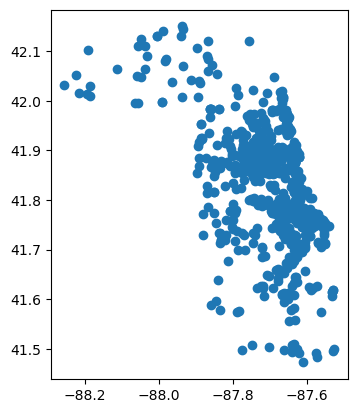

In [46]:
opioid_primary.plot()

In [47]:
# Calculate mean values for longitude and latitude to center map
long_mean = opioid_primary.longitude.mean()
lat_mean = opioid_primary.latitude.mean()
print(lat_mean)
print(long_mean)

41.831340446351525
-87.71142474242342


In [48]:
# Generate map of overdose deaths related to just opiates in Chicago from 2021 to the present
m = folium.Map(location=[lat_mean,long_mean])
for index, row in opioid_primary.iterrows():
    folium.Marker(location=[row.latitude, row.longitude]).add_to(m)
m.save('od_map.html')
m